# Dropped Tarots

## Problem statement

Oops! I dropped some tarot cards into a box of pixels. Can you help me retrieve them?

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [1]:
!curl https://storage.googleapis.com/aiolympiadmy/ioai-2025-tsp/ioai2025_tsp_selection2/dropped_tarots/dropped_tarots.npy -o dropped_tarots.npy

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 3037k    0 14835    0     0  60935      0  0:00:51 --:--:--  0:00:51 61301
100 3037k  100 3037k    0     0  8587k      0 --:--:-- --:--:-- --:--:-- 8629k


In [2]:
X = np.load("dropped_tarots.npy")

In [3]:
def visualize_pointcloud(pointcloud, elev=30, azim=30):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Extract spatial and color data
    x = pointcloud[:, 0]
    y = pointcloud[:, 1]
    z = pointcloud[:, 2]
    colors = pointcloud[:, 3:6]
    
    scatter = ax.scatter(x, y, z, c=colors, s=20)
    
    # Set axis labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Set view angle
    ax.view_init(elev=elev, azim=azim)
    
    # Set equal aspect ratio
    ax.set_box_aspect([1, 1, 1])
    
    plt.tight_layout()
    plt.show()

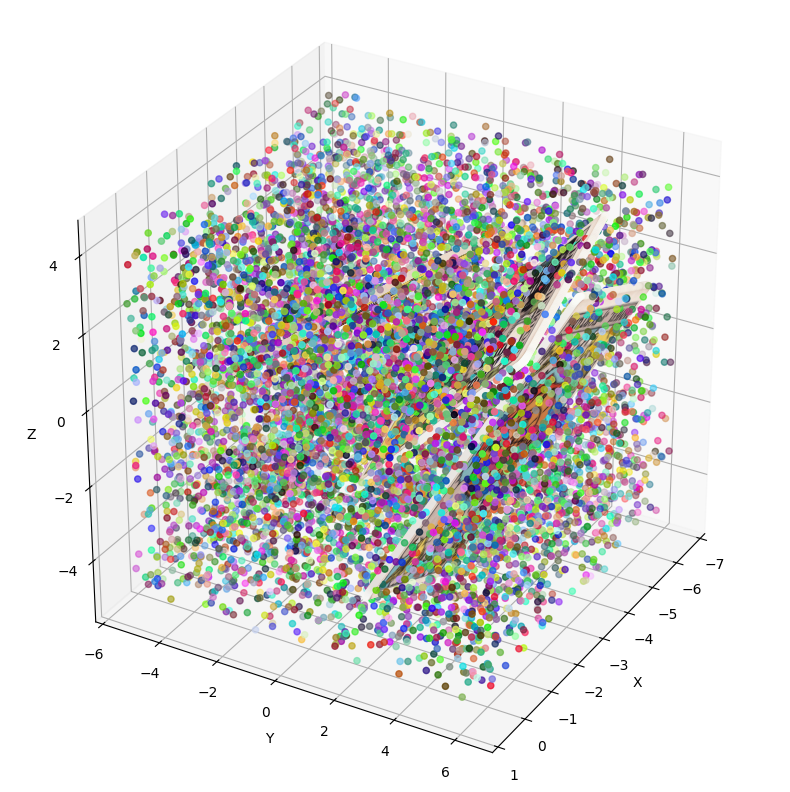

In [4]:
visualize_pointcloud(X)

Here is how your work will be scored:

- 1 pt awarded for demonstrating every single card retrieved from the box, and plotted in notebook as individual images. All cards need to be **upright**. The card labels should be directly readeable without requiring us to tilt our heads. 
- 1 pt awarded for demonstrating every single card retrieved from the box, plotted in notebook as individual images and show that they are **perfectly upright**.
- 1 pt awarded for demonstrating every single card retrieved from the box, plotted in notebook as individual images and have them be perfectly upright and are **noise-free**.
- 2 pts awarded for reconstructing the original scene above, excluding noise. You must start from your own retrieved images that are in 2D, and arrive at a tensor with similar dimensions as the orignal `dropped_tarot.npy` albeit with different length. Capped to 1 pt only if your retrieved images are not perfectly upright and are not perfectly noise-free.
- 1 pt awarded for explaining your thought process and reasoning for your work done. Keep it brief, one short paragraph is enough!

Partial credit to be granted at discretion.

Definitions:

- Upright means:
    - the card is oriented correctly with label at the bottom, and
    - the letters of the label are in correct left to right order, and
    - the card should have <= 20 degrees rotation.
- Perfectly upright means in addition to the definition of upright above, each image should have exactly zero rotation, and thus have exactly the same dimensions as the original image. 
- No noise means each image does not contain any noise pixels, and only contains identical pixel values as the original image.

## Your work below

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import RANSACRegressor
from scipy.spatial import ConvexHull
from scipy.interpolate import griddata

def detect_planes(points, colors, min_samples=100, residual_threshold=0.01, max_trials=1000):
    remaining_points, remaining_colors = points.copy(), colors.copy()
    planes = []

    while len(remaining_points) > min_samples:
        ransac = RANSACRegressor(residual_threshold=residual_threshold, max_trials=max_trials)
        ransac.fit(remaining_points[:, :2], remaining_points[:, 2])
        inliers = ransac.inlier_mask_

        if inliers.sum() < min_samples:
            break

        planes.append((remaining_points[inliers], remaining_colors[inliers]))
        remaining_points, remaining_colors = remaining_points[~inliers], remaining_colors[~inliers]

    return planes

def pca_project(points):
    pca = PCA(n_components=2)
    return pca.fit_transform(points), pca

def min_bounding_rectangle(points):
    hull = ConvexHull(points)
    hull_points = points[hull.vertices]
    edges = np.diff(hull_points, axis=0)
    angles = np.unique(np.arctan2(edges[:, 1], edges[:, 0]))

    rotations = np.array([
        [[np.cos(a), np.sin(a)], [-np.sin(a), np.cos(a)]]
        for a in angles
    ])
    rotated = np.einsum('aij,nj->ani', rotations, hull_points)
    
    mins, maxs = rotated.min(axis=1), rotated.max(axis=1)
    areas = np.prod(maxs - mins, axis=1)
    idx = np.argmin(areas)

    return angles[idx], maxs[idx] - mins[idx], rotations[idx]

def rotate_points(points, angle):
    c, s = np.cos(angle), np.sin(angle)
    return points @ np.array([[c, -s], [s, c]]).T

def variance_of_colors(colors):
    return np.var(colors, axis=0).mean()

def create_card_image(proj_points, colors, resolution=300):
    x, y = proj_points[:, 0], proj_points[:, 1]
    xi = np.linspace(x.min(), x.max(), resolution)
    yi = np.linspace(y.min(), y.max(), resolution)
    Xi, Yi = np.meshgrid(xi, yi)

    R = griddata(proj_points, colors[:, 0], (Xi, Yi), method='nearest')
    G = griddata(proj_points, colors[:, 1], (Xi, Yi), method='nearest')
    B = griddata(proj_points, colors[:, 2], (Xi, Yi), method='nearest')

    mask = ~np.isnan(R)
    image_rgb = np.stack((R, G, B), axis=-1).astype(np.uint8)
    alpha = np.where(mask, 255, 0).astype(np.uint8)

    return np.dstack((image_rgb, alpha)), mask

def reconstruct_3d(image, proj_points, colors, pca, resolution=300):
    x_min, y_min = proj_points.min(axis=0)
    x_max, y_max = proj_points.max(axis=0)

    xs = np.linspace(x_min, x_max, resolution)
    ys = np.linspace(y_max, y_min, resolution)

    new_points, new_colors = [], []

    for y_idx, y in enumerate(ys):
        for x_idx, x in enumerate(xs):
            if image[y_idx, x_idx, 3] > 0:
                pt_2d = [x, y]
                pt_3d = pca.inverse_transform([pt_2d])[0]
                new_points.append(pt_3d)
                new_colors.append(image[y_idx, x_idx, :3])

    return np.array(new_points), np.array(new_colors)

# === Main Execution ===
X = np.load("dropped_tarots.npy")
points, colors = X[:, :3], (X[:, 3:6] * 255).astype(np.uint8)

planes = detect_planes(points, colors)
all_3d_points, all_3d_colors = [], []

for idx, (plane_pts, plane_clrs) in enumerate(planes):
    proj, pca = pca_project(plane_pts)
    angle, dims, _ = min_bounding_rectangle(proj)
    rotated_proj = rotate_points(proj, -angle)

    img, _ = create_card_image(rotated_proj, plane_clrs)
    h = img.shape[0]
    top_strip = img[:h//10, :, :3].reshape(-1, 3)
    bottom_strip = img[int(h*0.9):, :, :3].reshape(-1, 3)

    if variance_of_colors(top_strip) > variance_of_colors(bottom_strip):
        rotated_proj[:, 1] *= -1

    image, _ = create_card_image(rotated_proj, plane_clrs)
    plt.imsave(f"tarot_card_{idx}.png", image)

    pts_3d, clrs_3d = reconstruct_3d(image, rotated_proj, plane_clrs, pca)
    all_3d_points.append(pts_3d)
    all_3d_colors.append(clrs_3d)

reconstructed_scene = np.hstack((
    np.vstack(all_3d_points),
    np.vstack(all_3d_colors) / 255.0
))

np.save("reconstructed_scene.npy", reconstructed_scene)
print(f"Reconstructed scene shape: {reconstructed_scene.shape}")

#visualize_pointcloud(reconstructed_scene)

Reconstructed scene shape: (270000, 6)


In [7]:
def npy_to_ply(input_npy_path, output_ply_path):
    """
    Convert a .npy point cloud to .ply format
    
    Args:
        input_npy_path: Path to input .npy file
        output_ply_path: Path to output .ply file
    """
    # Load point cloud data
    data = np.load(input_npy_path)
    
    # Extract coordinates and colors
    xyz = data[:, :3]
    rgb = (data[:, 3:] * 255).astype(np.uint8)  # Convert [0,1] float to [0,255] uint8
    
    # Write PLY header and data
    with open(output_ply_path, 'w') as f:
        f.write("ply\n")
        f.write("format ascii 1.0\n")
        f.write(f"element vertex {len(data)}\n")
        f.write("property float x\n")
        f.write("property float y\n")
        f.write("property float z\n")
        f.write("property uchar red\n")
        f.write("property uchar green\n")
        f.write("property uchar blue\n")
        f.write("end_header\n")
        
        # Write each point
        for (x, y, z), (r, g, b) in zip(xyz, rgb):
            f.write(f"{x} {y} {z} {r} {g} {b}\n")

# Example usage
npy_to_ply("dropped_tarots.npy", "dropped_tarots.ply")
npy_to_ply("reconstructed_scene.npy", "reconstructed_scene.ply")

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import RANSACRegressor
from scipy.spatial import ConvexHull
import matplotlib.path as mpl_path
from scipy.spatial import cKDTree
import os

def read_ply(ply_path):
    """Read PLY file with format: x,y,z,red,green,blue"""
    with open(ply_path, 'r') as f:
        lines = f.readlines()
    
    # Find header end
    header_end = 0
    for i, line in enumerate(lines):
        if "end_header" in line:
            header_end = i + 1
            break
    
    # Parse data
    data = []
    for line in lines[header_end:]:
        if line.strip():
            data.append(line.split())
    
    data = np.array(data, dtype=float)
    points = data[:, :3]
    colors = data[:, 3:6] / 255.0  # Normalize to [0,1]
    return points, colors

def detect_planes(points, colors, min_samples=100, residual_threshold=0.01, max_trials=1000):
    """Detect planes using RANSAC"""
    remaining_points = points.copy()
    remaining_colors = colors.copy()
    planes = []
    
    for _ in range(3):  # Find 3 largest planes
        if len(remaining_points) < min_samples:
            break
            
        ransac = RANSACRegressor(
            residual_threshold=residual_threshold,
            max_trials=max_trials
        )
        ransac.fit(remaining_points[:, :2], remaining_points[:, 2])
        
        if not hasattr(ransac, 'inlier_mask_'):
            break
            
        inlier_mask = ransac.inlier_mask_
        if np.sum(inlier_mask) < min_samples:
            break
            
        # Store inliers as a plane
        plane_points = remaining_points[inlier_mask]
        plane_colors = remaining_colors[inlier_mask]
        planes.append((plane_points, plane_colors))
        
        # Remove inliers for next iteration
        outlier_mask = ~inlier_mask
        remaining_points = remaining_points[outlier_mask]
        remaining_colors = remaining_colors[outlier_mask]
    
    return planes

def world_up_aligned_projection(points):
    """Project points to 2D with world-up alignment"""
    pca = PCA(n_components=3)
    pca.fit(points)
    centroid = pca.mean_
    normal = pca.components_[2]
    
    # World up vector (Z-axis)
    world_up = np.array([0, 0, 1])
    proj_up = world_up - np.dot(world_up, normal) * normal
    proj_up /= np.linalg.norm(proj_up)
    
    right = np.cross(normal, proj_up)
    right /= np.linalg.norm(right)
    
    # Project points
    centered = points - centroid
    proj_x = np.dot(centered, right)
    proj_y = np.dot(centered, proj_up)
    return np.column_stack((proj_x, proj_y)), centroid, right, proj_up, normal

def min_bounding_rotation(points):
    """Find optimal rotation to align with axes"""
    hull = ConvexHull(points)
    hull_pts = points[hull.vertices]
    edges = hull_pts[1:] - hull_pts[:-1]
    angles = np.arctan2(edges[:, 1], edges[:, 0])
    unique_angles = np.unique(angles)
    
    min_area = float('inf')
    best_angle = 0
    
    for angle in unique_angles:
        c, s = np.cos(angle), np.sin(angle)
        R = np.array([[c, -s], [s, c]])
        rotated = hull_pts @ R.T
        bbox = rotated.max(axis=0) - rotated.min(axis=0)
        area = bbox[0] * bbox[1]
        if area < min_area:
            min_area = area
            best_angle = angle
            
    return best_angle

def variance_of_colors(colors):
    """Measure color variance in a region"""
    return np.mean(np.var(colors, axis=0))

def create_card_image(projected, colors, resolution=1000):
    """Create high-resolution image from projected points"""
    # Normalize to [0, resolution-1]
    xmin, ymin = projected.min(axis=0)
    xmax, ymax = projected.max(axis=0)
    width = max(xmax - xmin, ymax - ymin) or 1.0  # Avoid division by zero
    
    scaled = (projected - [xmin, ymin]) / width * (resolution - 1)
    
    # Create grid
    grid_x, grid_y = np.meshgrid(
        np.linspace(0, resolution-1, resolution),
        np.linspace(0, resolution-1, resolution)
    )
    grid_points = np.column_stack((grid_x.ravel(), grid_y.ravel()))
    
    # Convex hull mask
    hull = ConvexHull(scaled)
    hull_path = mpl_path.Path(scaled[hull.vertices])
    mask = hull_path.contains_points(grid_points)
    
    # Nearest neighbor coloring
    tree = cKDTree(scaled)
    _, indices = tree.query(grid_points)
    grid_colors = colors[indices]
    
    # Build image (RGBA)
    image = np.zeros((resolution, resolution, 4), dtype=np.uint8)
    image_rgb = (grid_colors * 255).astype(np.uint8).reshape(resolution, resolution, 3)
    alpha = (mask * 255).astype(np.uint8).reshape(resolution, resolution)
    
    image[..., :3] = image_rgb
    image[..., 3] = alpha
    
    return image

def process_tarot_cards(ply_path, output_dir):
    """Main processing pipeline"""
    os.makedirs(output_dir, exist_ok=True)
    points, colors = read_ply(ply_path)
    planes = detect_planes(points, colors)
    
    for i, (plane_points, plane_colors) in enumerate(planes):
        # Project to 2D with world-up alignment
        projected, _, _, _, _ = world_up_aligned_projection(plane_points)
        
        # Rotate to minimize bounding box
        angle = min_bounding_rotation(projected)
        c, s = np.cos(-angle), np.sin(-angle)
        R = np.array([[c, -s], [s, c]])
        rotated_projected = projected @ R.T
        
        # Check orientation (label at bottom)
        height = rotated_projected[:, 1].max() - rotated_projected[:, 1].min()
        top_region = rotated_projected[rotated_projected[:, 1] < rotated_projected[:, 1].min() + 0.2 * height]
        bottom_region = rotated_projected[rotated_projected[:, 1] > rotated_projected[:, 1].max() - 0.2 * height]
        
        if len(top_region) > 10 and len(bottom_region) > 10:
            top_colors = plane_colors[rotated_projected[:, 1] < rotated_projected[:, 1].min() + 0.2 * height]
            bottom_colors = plane_colors[rotated_projected[:, 1] > rotated_projected[:, 1].max() - 0.2 * height]
            
            if variance_of_colors(top_colors) > variance_of_colors(bottom_colors):
                rotated_projected[:, 1] = -rotated_projected[:, 1]
        
        # Create and save image
        image = create_card_image(rotated_projected, plane_colors)
        plt.imsave(f"{output_dir}/card_{i}.png", image)

# Example usage
process_tarot_cards("dropped_tarots.ply", "tarot_cards")

In [9]:
import cv2
import numpy as np
import os

def order_points(pts):
    """
    Sorts a list of 4 coordinates in top-left, top-right, 
    bottom-right, bottom-left order. This is crucial for the 
    perspective transform.
    """
    rect = np.zeros((4, 2), dtype="float32")
    
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    return rect

def crop_and_straighten(image, corners):
    """
    Crops a quadrilateral defined by `corners` from the `image` 
    and returns it as a straightened, perfectly upright rectangle.
    """
    ordered_corners = order_points(corners)
    (tl, tr, br, bl) = ordered_corners
    
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    
    dst_rect = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")
        
    M = cv2.getPerspectiveTransform(ordered_corners, dst_rect)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    
    h, w, _ = warped.shape
    if w > h:
        warped = cv2.rotate(warped, cv2.ROTATE_90_CLOCKWISE)
        h, w, _ = warped.shape
    
    top_strip = warped[0:h//10, :]
    bottom_strip = warped[9*h//10:h, :]
    if cv2.Laplacian(top_strip, cv2.CV_64F).var() > cv2.Laplacian(bottom_strip, cv2.CV_64F).var():
        warped = cv2.rotate(warped, cv2.ROTATE_180)

    return warped

# --- Main execution ---
# Dictionary containing your image names and their corresponding corner coordinates.
# NOTE: The filenames must match exactly what you have on your disk.
card_data = {
    "tarot_cards/card_0.png": np.array([[804, 868], [379, 993], [547, 4], [118, 132]], dtype="float32"),
    "tarot_cards/card_1.png": np.array([[463, 75], [990, 587], [738, 849], [210, 333]], dtype="float32"),
    "tarot_cards/card_2.png": np.array([[449, 182], [744, 397], [303, 993], [7, 772]], dtype="float32")
}

# Loop through each image, process it, and save the result.
for filename, coords in card_data.items():
    try:
        # Check if the source file exists before trying to read it.
        if not os.path.exists(filename):
            print(f"Error: Source file not found at '{filename}'. Skipping.")
            continue
            
        # Load the original image.
        original_image = cv2.imread(filename)
        
        # Perform the crop and straightening operation.
        cropped_card = crop_and_straighten(original_image, coords)

        # Define the new filename for the output image.
        # This will create files like 'cropped_image.png'.
        path_parts = os.path.splitext(filename)
        new_filename = f"{path_parts[0]}_cropped{path_parts[1]}"
        
        # Save the resulting cropped card to the disk.
        cv2.imwrite(new_filename, cropped_card)
        
        print(f"Successfully processed '{filename}' and saved as '{new_filename}'")

    except Exception as e:
        print(f"An error occurred while processing {filename}: {e}")

Successfully processed 'tarot_cards/card_0.png' and saved as 'tarot_cards/card_0_cropped.png'
Successfully processed 'tarot_cards/card_1.png' and saved as 'tarot_cards/card_1_cropped.png'
Successfully processed 'tarot_cards/card_2.png' and saved as 'tarot_cards/card_2_cropped.png'


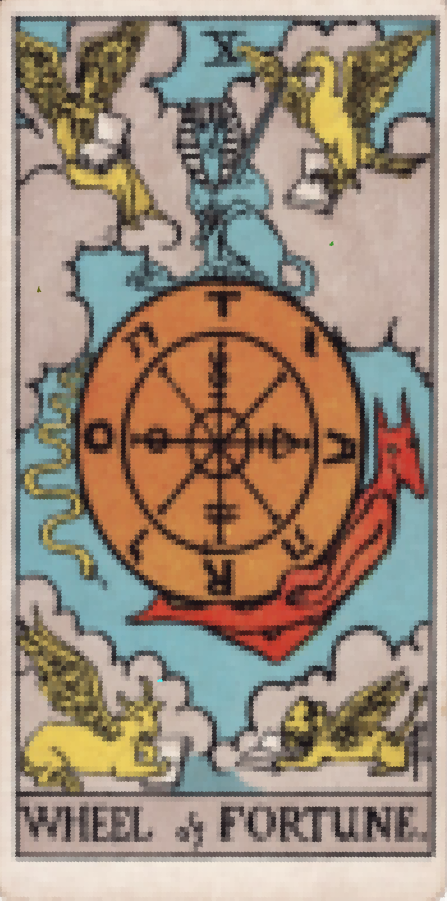

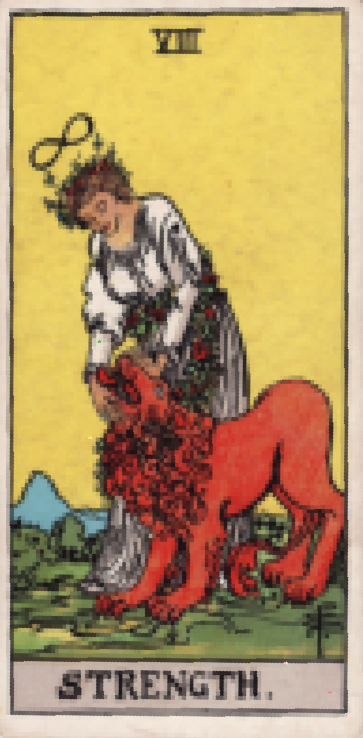

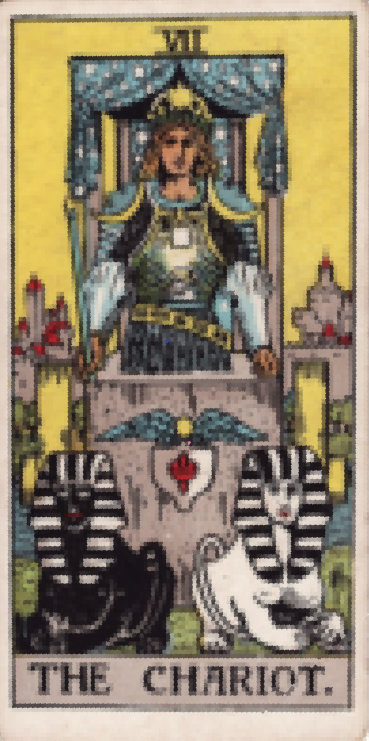

In [10]:
# importing PIL Module
from PIL import Image

# open the original image
card0 = Image.open("tarot_cards/card_0_cropped.png").rotate(180)
card1 = Image.open("tarot_cards/card_1_cropped.png")
card2 = Image.open("tarot_cards/card_2_cropped.png").transpose(method=Image.FLIP_LEFT_RIGHT)

card0.save("CARD0.png")
card1.save("CARD1.png")
card2.save("CARD2.png")
# Flip the original image horizontally
display(card0)
display(card1)
display(card2)

Card 0: 402747 points
Card 1: 267894 points
Card 2: 273429 points
Final scene contains 944070 points


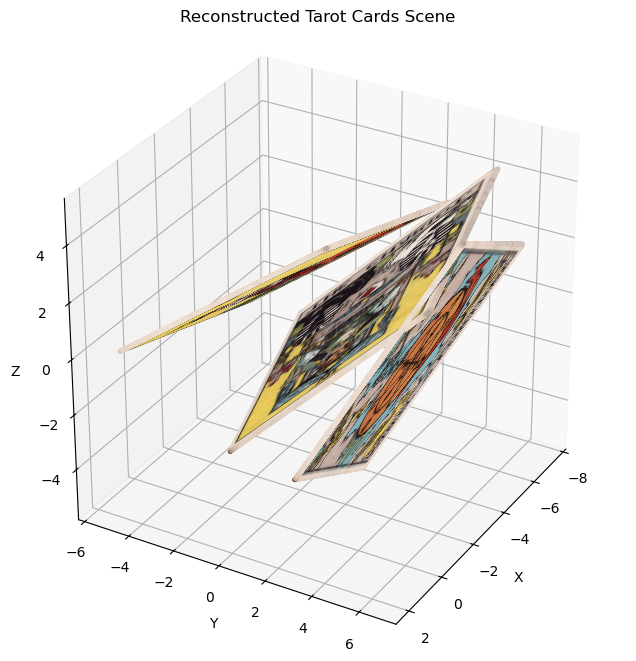

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import RANSACRegressor
import matplotlib.image as mpimg

# Load original data
X = np.load("dropped_tarots.npy")
points = X[:, :3]
colors = X[:, 3:6]

def detect_planes(points, min_samples=100):
    """Detect card planes using RANSAC"""
    planes = []
    remaining = points.copy()
    
    while len(remaining) > min_samples:
        ransac = RANSACRegressor(residual_threshold=0.01)
        ransac.fit(remaining[:, :2], remaining[:, 2])
        
        if not hasattr(ransac, 'inlier_mask_'):
            break
            
        inliers = remaining[ransac.inlier_mask_]
        planes.append(inliers)
        remaining = remaining[~ransac.inlier_mask_]
    
    return planes

def project_to_2d(plane_points):
    """Create 2D projection of plane points"""
    pca = PCA(n_components=2)
    proj_2d = pca.fit_transform(plane_points)
    return proj_2d, pca

def create_3d_card(image, proj_2d, pca):
    """Create 3D card points from 2D image"""
    h, w = image.shape[:2]
    x_min, y_min = proj_2d.min(axis=0)
    x_max, y_max = proj_2d.max(axis=0)
    
    card_points = []
    card_colors = []
    
    # Convert to RGBA if needed
    if image.shape[2] == 3:
        # Add alpha channel (255 = fully opaque)
        image = np.dstack((image, np.ones((h, w, 1))))
    
    for i in range(h):
        for j in range(w):
            # Use alpha channel if exists, otherwise assume all pixels are valid
            if image.shape[2] > 3 and image[i, j, 3] <= 0.01:  # Near transparent
                continue
                
            # Map pixel to 2D plane coordinates
            x_2d = x_min + j * (x_max - x_min) / (w - 1)
            y_2d = y_min + (h - 1 - i) * (y_max - y_min) / (h - 1)  # Flip Y
            
            # Project back to 3D
            point_3d = pca.inverse_transform([(x_2d, y_2d)])
            card_points.append(point_3d[0])
            card_colors.append(image[i, j, :3])  # Keep RGB only
    
    return np.array(card_points), np.array(card_colors)

# Detect card planes in original point cloud
planes = detect_planes(points)

# Load your pre-processed card images
card_images = [
    mpimg.imread("CARD0.png"),
    mpimg.imread("CARD1.png"),
    mpimg.imread("CARD2.png")
]

# Reconstruct 3D cards from 2D images
reconstructed_cards = []
for i, (plane, image) in enumerate(zip(planes, card_images)):
    proj_2d, pca = project_to_2d(plane)
    card_points, card_colors = create_3d_card(image, proj_2d, pca)
    reconstructed_cards.append(np.hstack((card_points, card_colors)))
    
    # Display card info
    print(f"Card {i}: {len(card_points)} points")

# Combine all cards into final scene
final_scene = np.vstack(reconstructed_cards)
np.save("reconstructed_scene.npy", final_scene)

# Visualization
def visualize_pointcloud(pointcloud, elev=30, azim=30):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    x, y, z = pointcloud[:, 0], pointcloud[:, 1], pointcloud[:, 2]
    ax.scatter(x, y, z, c=pointcloud[:, 3:6], s=5)
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ax.view_init(elev=elev, azim=azim)
    ax.set_box_aspect([1, 1, 1])
    plt.title("Reconstructed Tarot Cards Scene")
    plt.show()

print(f"Final scene contains {len(final_scene)} points")
visualize_pointcloud(final_scene)

# Plane Detection: Use the RANSAC algorithm to detect planar segments in the point cloud. Each segment represents a tarot card.
# Projection to 2D: For each detected plane, project the 3D points onto a 2D plane to form an image.
# Color Mapping: Map the colors from the 3D points to the 2D image grid.
# Image Extraction: Save each projected plane as a separate image representing a tarot card.